# Investigating which areas show significant second level effects at which times

In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import source_visualisations as sv
import mne

## Data preparation
Which data?

In [2]:
# baseline [-0.3, 0], trialregs_dot=5
# basefile = 'source_HCPMMP1_allsubs_201703301614.h5'

# baseline None, trialregs_dot=5
#basefile = 'source_HCPMMP1_allsubs_201706091054.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space
#basefile = 'source_sequential_201706141650.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space, move_dist, sum_dot_y
#basefile = 'source_sequential_201706191442.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space, move_dist, 
# sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706201654.h5'

# baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, GLM in source space, move_dist, 
# sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706261151.h5'

# label mode = (abs)max, baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, GLM in source space, 
# move_dist, sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706281100.h5'

# baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, move_dist, 
# sum_dot_y, constregs=0 for 1st dot, 
# label_tc normalised across trials, times and subjects
basefile = 'source_sequential_201707031206.h5'

choose measure and identify threshold

In [3]:
# e.g.: mu_p_large, mu_testval, mu_t, mu_mean
measure = 'mu_p_large'

# which regressors should define the empirical value distribution?
# set regressors = None for all
regressors = ['dot_x', 'dot_y', 'abs_dot_x', 'abs_dot_y']

# do not use these regressors to define empirical value distribution
exclude = 'trialregs'

# the empiric error threshold for a single time point and area
# (the selected threshold will be the quantile 1-alpha of the 
# empirical distribution of measure values)
alpha = 0.05

threshold, measure_cdf = sv.find_slabs_threshold(
    basefile, measure, quantile=1-alpha, regressors=regressors, 
    exclude=exclude, verbose=1, return_cdf=True)

print('\nthreshold = {:.4f}'.format(threshold))

excluding:
intercept
entropy
response
trial_time

adding abs_dot_x
adding abs_dot_y
adding dot_x
adding dot_y
N = 101360

threshold = 0.5100


what are large values for the possible measures (used for setting y-lim in plotting)

In [4]:
ylims = {'mu_p_large': 1, 'mu_t': 8, 'mu_z': 8, 'mu_testval': 0.02, 'mu_mean': 0.04}
logy = {'mu_p_large': False, 'mu_t': False, 'mu_z': False, 'mu_testval': True, 'mu_mean': False}

## Load data for all selected regressors and identify significant clusters in time
The idea is that you identify sequences of high measure values that cannot happen by chance. This is all based on the empirical measure distribution used above. This distribution defines the probability with which I would get a particular measure value, if I were to draw one randomly across locations, time points and regressors. So it is a permutation distribution. I then use the cumulative density function of this distribution to first select a cluster threshold, i.e., a measure value which has to be exceeded in order to form a sequence cluster. Then I identify clusters, i.e., sequences of measure values within an area that exceed the threshold. The p-value of the found cluster is the product of 1-cdf(value) for the measure values in the sequence.

In [5]:
clusters = []
for r_name in regressors:
    srcfile = basefile[:-3] + '_slabs_%s.h5' % r_name
    file = 'mne_subjects/fsaverage/bem/' + srcfile
    src_df = pd.read_hdf(file, 'second_level_src')
    clusters.append(sv.get_time_clusters(src_df[measure], threshold, measure_cdf))

clusters = pd.concat(clusters, keys=regressors, names=['regressor', 'cluster'])
clusters.label.groupby(level='regressor').count()

regressor
dot_x        1088
dot_y         512
abs_dot_x     852
abs_dot_y     573
Name: label, dtype: int64

now FDR-correct the found clusters

In [6]:
cluster_alpha = 0.001
reject, pval = mne.stats.fdr_correction(10**clusters.log10p, cluster_alpha)
clusters['pval_corrected'] = pval
clusters = clusters[reject]

# add region of area for information
def get_region(area):
    if area.startswith('??'):
        section = 'whole hemisphere'
    else:
        section = sv.Glasser_areas[sv.Glasser_areas['area name'] == area[2:-7]]['main section']
        section = sv.Glasser_sections.loc[section].name.values[0]
    
    return section
clusters['region'] = clusters.label.apply(get_region)

clusters.sort_values('start_t').sort_index(level='regressor', sort_remaining=False)

label  start_t  end_t     log10p  pval_corrected  \
regressor cluster                                                              
dot_x     103         L_5L_ROI-lh       30     80  -9.612352    6.535747e-09   
          979         R_V2_ROI-rh      100    130 -10.386901    1.193414e-09   
          718        R_DVT_ROI-rh      100    130  -6.822627    2.556690e-06   
          421        L_V3A_ROI-lh      110    130  -5.260115    7.055753e-05   
          908       R_ProS_ROI-rh      110    130  -4.809204    1.784704e-04   
          415         L_V2_ROI-lh      110    130  -6.834924    2.544640e-06   
          998         R_V3_ROI-rh      110    130  -6.442309    5.905340e-06   
          518      L_v23ab_ROI-lh      110    130  -7.546101    5.659540e-07   
          424        L_V3B_ROI-lh      110    140  -6.832061    2.544640e-06   
          1084     R_v23ab_ROI-rh      110    120  -5.361814    5.717196e-05   
          431         L_V3_ROI-lh      110    130  -7.534665    5.735086e-07   
          411         L_V1_ROI-lh      110    140  -9.921946    3.415654e-09   
          916         R_RI_ROI-rh      120    130  -4.001448    8.688569e-04   
          1019       R_VIP_ROI-rh      140    180  -8.960248    2.739633e-08   
          1005       R_V6A_ROI-rh      140    190 -11.513333    9.974925e-11   
          767       R_IPS1_ROI-rh      140    190 -12.128380    2.587175e-11   
          519      L_v23ab_ROI-lh      150    190 -11.856874    4.725651e-11   
          659        R_7Am_ROI-rh      150    180 -10.622633    7.285462e-10   
          1014        R_V7_ROI-rh      150    200 -17.719554    1.202072e-16   
          329       L_POS2_ROI-lh      150    200 -13.801979    6.916669e-13   
          719        R_DVT_ROI-rh      150    190 -14.066126    4.059004e-13   
          757        R_IP0_ROI-rh      150    190 -14.344911    2.317192e-13   
          1085     R_v23ab_ROI-rh      150    200 -12.168070    2.416775e-11   
          840        R_PCV_ROI-rh      150    180  -7.221418    1.135500e-06   
          221       L_IPS1_ROI-lh      150    200 -14.804310    8.184417e-14   
          871        R_PGp_ROI-rh      150    190 -10.446584    1.060574e-09   
          46           L_2_ROI-lh      150    180  -9.769373    4.676918e-09   
          127        L_7Am_ROI-lh      150    180  -9.151926    1.791648e-08   
          166        L_DVT_ROI-lh      150    200 -15.298412    2.766624e-14   
          986        R_V3B_ROI-rh      160    180  -6.249052    8.879173e-06   
...                           ...      ...    ...        ...             ...   
abs_dot_x 536        R_FFC_ROI-rh      490    510  -4.388570    3.925050e-04   
          339       L_VMV2_ROI-lh      520    540  -4.468832    3.391958e-04   
          571        R_IP1_ROI-rh      530    550  -5.216035    7.728819e-05   
          850      R_v23ab_ROI-rh      580    600  -4.351296    4.249820e-04   
          521        R_AVI_ROI-rh      590    610  -4.640719    2.458454e-04   
          277        L_RSC_ROI-lh      640    650  -4.067124    7.578366e-04   
          818      R_d23ab_ROI-rh      650    660  -4.439099    3.596710e-04   
          771         R_V2_ROI-rh      650    670  -4.759763    1.955284e-04   
          47          L_3b_ROI-lh      660    690  -5.555243    3.743689e-05   
abs_dot_y 238        L_VIP_ROI-lh       20     40  -5.849665    1.988940e-05   
          139        L_LO1_ROI-lh      150    170  -5.332904    6.065997e-05   
          97         L_DVT_ROI-lh      160    180  -4.400591    3.857024e-04   
          229        L_V6A_ROI-lh      170    190  -4.538901    2.974932e-04   
          508         R_V4_ROI-rh      170    190  -4.434658    3.610078e-04   
          258      L_d23ab_ROI-lh      180    220  -9.826133    4.141576e-09   
          30        L_31pd_ROI-lh      190    210  -5.258223    7.055753e-05   
          9          L_23d_ROI-lh      190    220  -6.108009    1.191382e-05   
          78          L_7m_R

In [7]:
clusters.label.groupby(level='regressor').count()

regressor
dot_x        234
dot_y         46
abs_dot_x     50
abs_dot_y     21
Name: label, dtype: int64

## Find all clusters of a given area or region

In [8]:
area = 'v23ab'
clusters[clusters.label.apply(lambda s: s.find(area) >= 0)]

label  start_t  end_t     log10p  pval_corrected  \
regressor cluster                                                              
dot_x     518      L_v23ab_ROI-lh      110    130  -7.546101    5.659540e-07   
          519      L_v23ab_ROI-lh      150    190 -11.856874    4.725651e-11   
          521      L_v23ab_ROI-lh      290    560 -72.412068    5.856350e-70   
          1084     R_v23ab_ROI-rh      110    120  -5.361814    5.717196e-05   
          1085     R_v23ab_ROI-rh      150    200 -12.168070    2.416775e-11   
          1087     R_v23ab_ROI-rh      290    560 -74.232264    1.771991e-71   
abs_dot_x 850      R_v23ab_ROI-rh      580    600  -4.351296    4.249820e-04   
abs_dot_y 570      R_v23ab_ROI-rh      190    210  -4.325864    4.477858e-04   

                                       region  
regressor cluster                              
dot_x     518      posterior cingulate cortex  
          519      posterior cingulate cortex  
          521      posterior cingulate cortex  
          1084     posterior cingulate cortex  
          1085     posterior cingulate cortex  
          1087     posterior cingulate cortex  
abs_dot_x 850      posterior cingulate cortex  
abs_dot_y 570      posterior cingulate cortex

In [9]:
region = 'dorsolat'
clusters[clusters.region.apply(lambda s: s.find(region) >= 0)]

label  start_t  end_t    log10p  pval_corrected  \
regressor cluster                                                              
dot_x     147         L_8BL_ROI-lh      420    430 -4.026945        0.000824   
          155          L_8C_ROI-lh      440    460 -5.489748        0.000043   
          377         L_SFL_ROI-lh      450    480 -6.862985        0.000002   
          1049       R_i6-8_ROI-rh      440    460 -5.257434        0.000071   
abs_dot_x 348      L_a9-46v_ROI-lh      290    310 -4.002392        0.000869   
          370        L_s6-8_ROI-lh      310    340 -6.662790        0.000004   
          489         R_8Av_ROI-rh      310    320 -3.950332        0.000969   
          494          R_8C_ROI-rh      330    350 -4.882728        0.000152   
          503          R_9p_ROI-rh      320    330 -3.951344        0.000969   

                                           region  
regressor cluster                                  
dot_x     147      dorsolateral prefrontal cortex  
          155      dorsolateral prefrontal cortex  
          377      dorsolateral prefrontal cortex  
          1049     dorsolateral prefrontal cortex  
abs_dot_x 348      dorsolateral prefrontal cortex  
          370      dorsolateral prefrontal cortex  
          489      dorsolateral prefrontal cortex  
          494      dorsolateral prefrontal cortex  
          503      dorsolateral prefrontal cortex

## Investigate individual regressors

In [10]:
r_name = 'dot_x'
r_clusters = clusters.xs(r_name, level='regressor').copy()

srcfile = basefile[:-3] + '_slabs_%s.h5' % r_name
file = 'mne_subjects/fsaverage/bem/' + srcfile
src_df = pd.read_hdf(file, 'second_level_src')

### Check the times at which we see significant clusters

<IPython.core.display.Javascript object>


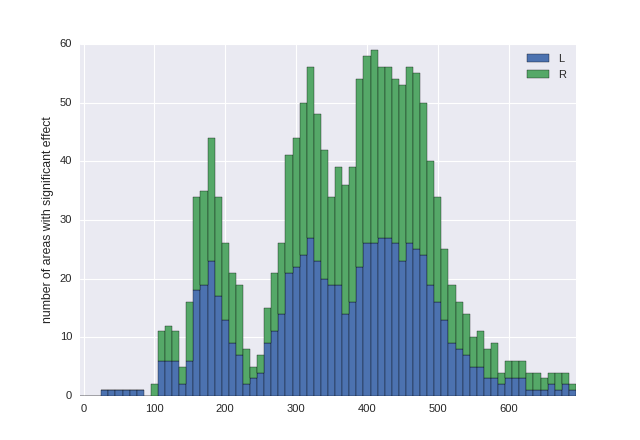

In [11]:
times = src_df[measure].index.levels[1]
sigareas = r_clusters.label.unique()
significant = pd.DataFrame(np.zeros((sigareas.size, times.size), bool), 
                           index=sigareas, columns=times)
for row in r_clusters.itertuples():
    significant.loc[row.label, slice(row.start_t, row.end_t)] = True
    
fig, ax = plt.subplots()
left = significant.columns - 5
colors = plt.rcParams['axes.prop_cycle']._left

# plot left hemi 
numlh = significant[significant.index.map(lambda l: l[0]) == 'L'].sum()
ax.bar(left, height=numlh, width=10, bottom=0, color=colors[0]['color'])
# plot right hemi
ax.bar(left, 
       height=significant[significant.index.map(lambda l: l[0]) == 'R'].sum(), 
       width=10, bottom=numlh, color=colors[1]['color'])
ax.set_ylabel('number of areas with significant effect');
ax.legend(['L', 'R']);
ax.set_xlim(left[0], left[-1]+10);

### Identify areas

In [12]:
def get_areas(times):
    if type(times) is not list:
        times = [times]
    
    return significant[np.all(significant[times], axis=1)].index

def active_areas(times, times2=None):
    """Returns areas that are reliably activated at all time points in times.
       If times2 is provided, intersection and set differences of areas 
       associated with times and times2 are indicated."""
    
    print(r_name)
    
    areas = get_areas(times)
    
    if times2 is None:
        areas2 = pd.Index([])
    else:
        areas2 = get_areas(times2)
    
    areas = pd.concat([pd.Series(areas.difference(areas2)), 
                       pd.Series(areas.intersection(areas2)), 
                       pd.Series(areas2.difference(areas))],
                      keys=['only 1', 'intersect', 'only 2'])
    areas = pd.DataFrame(areas, columns=['area'])
    
    areas['region'] = areas.area.apply(get_region)
    
    return areas

In [13]:
active_areas(120, 170)

dot_x


area                                        region
only 1    0      L_V1_ROI-lh                         primary visual cortex
          1     L_V3B_ROI-lh                   dorsal stream visual cortex
          2    R_ProS_ROI-rh                    posterior cingulate cortex
          3      R_RI_ROI-rh                         early auditory cortex
          4      R_V3_ROI-rh                           early visual cortex
intersect 0      L_V2_ROI-lh                           early visual cortex
          1     L_V3A_ROI-lh                   dorsal stream visual cortex
          2      L_V3_ROI-lh                           early visual cortex
          3   L_v23ab_ROI-lh                    posterior cingulate cortex
          4     R_DVT_ROI-rh                    posterior cingulate cortex
          5      R_V2_ROI-rh                           early visual cortex
          6   R_v23ab_ROI-rh                    posterior cingulate cortex
only 2    0       L_2_ROI-lh                somatosensory and motor cortex
          1     L_7Am_ROI-lh                      superior parietal cortex
          2      L_7m_ROI-lh                    posterior cingulate cortex
          3     L_AIP_ROI-lh                      superior parietal cortex
          4     L_DVT_ROI-lh                    posterior cingulate cortex
          5     L_IP0_ROI-lh                      inferior parietal cortex
          6     L_IP1_ROI-lh                      inferior parietal cortex
          7    L_IPS1_ROI-lh                   dorsal stream visual cortex
          8    L_LIPd_ROI-lh                      superior parietal cortex
          9    L_LIPv_ROI-lh                      superior parietal cortex
          10    L_MIP_ROI-lh                      superior parietal cortex
          11    L_PCV_ROI-lh                    posterior cingulate cortex
          12    L_PGs_ROI-lh                      inferior parietal cortex
          13   L_POS2_ROI-lh                    posterior cingulate cortex
          14    L_V6A_ROI-lh                   dorsal stream visual cortex
          15    R_5mv_ROI-rh  paracentral lobular and mid cingulate cortex
          16    R_7Am_ROI-rh                      superior parietal cortex
          17    R_IP0_ROI-rh                      inferior parietal cortex
          18    R_IP1_ROI-rh                      inferior parietal cortex
          19   R_IPS1_ROI-rh                   dorsal stream visual cortex
          20   R_LIPv_ROI-rh                      superior parietal cortex
          21    R_PCV_ROI-rh                    posterior cingulate cortex
          22    R_PGp_ROI-rh                      inferior parietal cortex
          23    R_V3B_ROI-rh                   dorsal stream visual cortex
          24    R_V6A_ROI-rh                   dorsal stream visual cortex
          25     R_V6_ROI-rh                   dorsal stream visual cortex
          26     R_V7_ROI-rh                   dorsal stream visual cortex
          27    R_VIP_ROI-rh                      superior parietal cortex

In [14]:
active_areas(320, 490)

dot_x


area                                           region
only 1    0     L_31a_ROI-lh                       posterior cingulate cortex
          1    L_31pd_ROI-lh                       posterior cingulate cortex
          2      L_5L_ROI-lh     paracentral lobular and mid cingulate cortex
          3      L_5m_ROI-lh     paracentral lobular and mid cingulate cortex
          4     L_5mv_ROI-lh     paracentral lobular and mid cingulate cortex
          5     L_7Am_ROI-lh                         superior parietal cortex
          6     L_LO1_ROI-lh         MT+ complex and neighboring visual areas
          7     L_MST_ROI-lh         MT+ complex and neighboring visual areas
          8     L_PCV_ROI-lh                       posterior cingulate cortex
          9     L_PIT_ROI-lh                     ventral stream visual cortex
          10  L_TPOJ2_ROI-lh               temporo-parieto-occipital junction
          11    L_V3B_ROI-lh                      dorsal stream visual cortex
          12   L_V3CD_ROI-lh         MT+ complex and neighboring visual areas
          13     L_V4_ROI-lh                              early visual cortex
          14  L_d23ab_ROI-lh                       posterior cingulate cortex
          15    R_31a_ROI-rh                       posterior cingulate cortex
          16   R_31pd_ROI-rh                       posterior cingulate cortex
          17   R_31pv_ROI-rh                       posterior cingulate cortex
          18    R_47s_ROI-rh                 orbital and polar frontal cortex
          19     R_5L_ROI-rh     paracentral lobular and mid cingulate cortex
          20     R_5m_ROI-rh     paracentral lobular and mid cingulate cortex
          21    R_7Am_ROI-rh                         superior parietal cortex
          22    R_7Pm_ROI-rh                         superior parietal cortex
          23    R_AIP_ROI-rh                         superior parietal cortex
          24   R_LIPv_ROI-rh                         superior parietal cortex
          25    R_PCV_ROI-rh                       posterior cingulate cortex
          26    R_RSC_ROI-rh                       posterior cingulate cortex
          27    R_V3A_ROI-rh                      dorsal stream visual cortex
          28  R_d23ab_ROI-rh                       posterior cingulate cortex
intersect 0       L_1_ROI-lh                   somatosensory and motor cortex
...                      ...                                              ...
          10   L_SCEF_ROI-lh     paracentral lobular and mid cingulate cortex
          11  L_v23ab_ROI-lh                       posterior cingulate cortex
          12      R_1_ROI-rh                   somatosensory and motor cortex
          13   R_24dv_ROI-rh     paracentral lobular and mid cingulate cortex
          14   R_33pr_ROI-rh  anterior cingulate and medial prefrontal cortex
          15     R_3b_ROI-rh                   somatosensory and motor cortex
          16      R_4_ROI-rh                   somatosensory and motor cortex
          17    R_5mv_ROI-rh     paracentral lobular and mid cingulate cortex
          18     R_6a_ROI-rh                                  premotor cortex
          19    R_6ma_ROI-rh     paracentral lobular and mid cingulate cortex
          20     R_7m_ROI-rh                       posterior cingulate cortex
          21    R_DVT_ROI-rh                       posterior cingulate cortex
          22   R_SCEF_ROI-rh     paracentral lobular and mid cingulate cortex
          23     R_V6_ROI-rh                      dorsal stream visual cortex
          24  R_p24pr_ROI-rh  anterior cingulate and medial prefrontal cortex
          25  R_p32pr_ROI-rh  anterior cingulate and medial prefrontal cortex
          26  R_v23ab_ROI-rh                       posterior cingulate cortex
only 2    0       L_2_ROI-lh                   somatosensory and motor cortex
          1     L_AIP_ROI-lh                         superior parietal cortex
          2     L_DVT_ROI-lh                  

In [15]:
active_areas(490, 600)

dot_x


area                                           region
only 1    0       L_1_ROI-lh                   somatosensory and motor cortex
          1    L_24dv_ROI-lh     paracentral lobular and mid cingulate cortex
          2       L_2_ROI-lh                   somatosensory and motor cortex
          3    L_31pv_ROI-lh                       posterior cingulate cortex
          4    L_33pr_ROI-lh  anterior cingulate and medial prefrontal cortex
          5      L_3a_ROI-lh                   somatosensory and motor cortex
          6      L_3b_ROI-lh                   somatosensory and motor cortex
          7       L_4_ROI-lh                   somatosensory and motor cortex
          8      L_6d_ROI-lh                                  premotor cortex
          9      L_7m_ROI-lh                       posterior cingulate cortex
          10    L_AIP_ROI-lh                         superior parietal cortex
          11    L_DVT_ROI-lh                       posterior cingulate cortex
          12    L_IP1_ROI-lh                         inferior parietal cortex
          13   L_IPS1_ROI-lh                      dorsal stream visual cortex
          14   L_LIPd_ROI-lh                         superior parietal cortex
          15   L_SCEF_ROI-lh     paracentral lobular and mid cingulate cortex
          16  L_p24pr_ROI-lh  anterior cingulate and medial prefrontal cortex
          17  L_v23ab_ROI-lh                       posterior cingulate cortex
          18      R_1_ROI-rh                   somatosensory and motor cortex
          19   R_24dv_ROI-rh     paracentral lobular and mid cingulate cortex
          20   R_33pr_ROI-rh  anterior cingulate and medial prefrontal cortex
          21     R_3b_ROI-rh                   somatosensory and motor cortex
          22      R_4_ROI-rh                   somatosensory and motor cortex
          23    R_5mv_ROI-rh     paracentral lobular and mid cingulate cortex
          24    R_6ma_ROI-rh     paracentral lobular and mid cingulate cortex
          25     R_7m_ROI-rh                       posterior cingulate cortex
          26    R_DVT_ROI-rh                       posterior cingulate cortex
          27    R_FEF_ROI-rh                                  premotor cortex
          28  R_OP2-3_ROI-rh                       posterior opercular cortex
          29   R_PFcm_ROI-rh                       posterior opercular cortex
          30   R_SCEF_ROI-rh     paracentral lobular and mid cingulate cortex
          31     R_V6_ROI-rh                      dorsal stream visual cortex
          32     R_V7_ROI-rh                      dorsal stream visual cortex
          33  R_a24pr_ROI-rh  anterior cingulate and medial prefrontal cortex
          34  R_p32pr_ROI-rh  anterior cingulate and medial prefrontal cortex
          35  R_v23ab_ROI-rh                       posterior cingulate cortex
intersect 0    L_POS2_ROI-lh                       posterior cingulate cortex
          1      R_6a_ROI-rh                                  premotor cortex
          2      R_6d_ROI-rh                                  premotor cortex
          3   R_p24pr_ROI-rh  anterior cingulate and medial prefrontal cortex
only 2    0      L_25_ROI-lh  anterior cingulate and medial prefrontal cortex
          1    L_FOP2_ROI-lh             insular and frontal opercular cortex

In [16]:
active_areas(300)

dot_x


area                                           region
only 1 0    L_24dv_ROI-lh     paracentral lobular and mid cingulate cortex
       1    L_31pd_ROI-lh                       posterior cingulate cortex
       2    L_31pv_ROI-lh                       posterior cingulate cortex
       3    L_33pr_ROI-lh  anterior cingulate and medial prefrontal cortex
       4      L_3a_ROI-lh                   somatosensory and motor cortex
       5      L_3b_ROI-lh                   somatosensory and motor cortex
       6       L_4_ROI-lh                   somatosensory and motor cortex
       7      L_5L_ROI-lh     paracentral lobular and mid cingulate cortex
       8     L_5mv_ROI-lh     paracentral lobular and mid cingulate cortex
       9     L_7Am_ROI-lh                         superior parietal cortex
       10     L_7m_ROI-lh                       posterior cingulate cortex
       11   L_LIPd_ROI-lh                         superior parietal cortex
       12    L_LO1_ROI-lh         MT+ complex and neighboring visual areas
       13    L_MST_ROI-lh         MT+ complex and neighboring visual areas
       14    L_PCV_ROI-lh                       posterior cingulate cortex
       15   L_SCEF_ROI-lh     paracentral lobular and mid cingulate cortex
       16  L_TPOJ2_ROI-lh               temporo-parieto-occipital junction
       17    L_V3B_ROI-lh                      dorsal stream visual cortex
       18   L_V3CD_ROI-lh         MT+ complex and neighboring visual areas
       19     L_V6_ROI-lh                      dorsal stream visual cortex
       20  L_d23ab_ROI-lh                       posterior cingulate cortex
       21  L_v23ab_ROI-lh                       posterior cingulate cortex
       22      R_1_ROI-rh                   somatosensory and motor cortex
       23    R_31a_ROI-rh                       posterior cingulate cortex
       24   R_31pd_ROI-rh                       posterior cingulate cortex
       25   R_31pv_ROI-rh                       posterior cingulate cortex
       26   R_33pr_ROI-rh  anterior cingulate and medial prefrontal cortex
       27     R_3b_ROI-rh                   somatosensory and motor cortex
       28      R_4_ROI-rh                   somatosensory and motor cortex
       29     R_5L_ROI-rh     paracentral lobular and mid cingulate cortex
       30     R_5m_ROI-rh     paracentral lobular and mid cingulate cortex
       31    R_5mv_ROI-rh     paracentral lobular and mid cingulate cortex
       32     R_6a_ROI-rh                                  premotor cortex
       33    R_6ma_ROI-rh     paracentral lobular and mid cingulate cortex
       34    R_7Am_ROI-rh                         superior parietal cortex
       35    R_AIP_ROI-rh                         superior parietal cortex
       36   R_LIPv_ROI-rh                         superior parietal cortex
       37    R_PCV_ROI-rh                       posterior cingulate cortex
       38    R_RSC_ROI-rh                       posterior cingulate cortex
       39   R_SCEF_ROI-rh     paracentral lobular and mid cingulate cortex
       40  R_d23ab_ROI-rh                       posterior cingulate cortex
       41  R_p24pr_ROI-rh  anterior cingulate and medial prefrontal cortex
       42  R_p32pr_ROI-rh  anterior cingulate and medial prefrontal cortex
       43  R_v23ab_ROI-rh                       posterior cingulate cortex

### Show significant clusters

In [17]:
def get_cluster_tcs(clus, baseval=0):

    mask = pd.Series(np.zeros_like(src_df[measure], dtype=bool), index=src_df[measure].index)
    for row in clus.itertuples():
        mask.loc[row.label, slice(row.start_t, row.end_t)] = True

    active = src_df[measure].where(mask, other=baseval)
    active = active.reset_index('label')
    active = active.pivot(columns='label')[measure]

    # get labels of active areas in given clusters
    maxvals = active.max()
    labels = maxvals.index[maxvals > baseval]

    # select only active areas
    active = active[labels]

    # get hemisphere of labels
    hemis = labels.map(lambda l: l[-2].upper())
    labels = labels.map(lambda l: l[2:-7])

    active.columns = pd.MultiIndex.from_arrays([hemis, labels],
                                               names=['hemi', 'label'])

    return active

### clusters from a particular region

dot_x


<IPython.core.display.Javascript object>


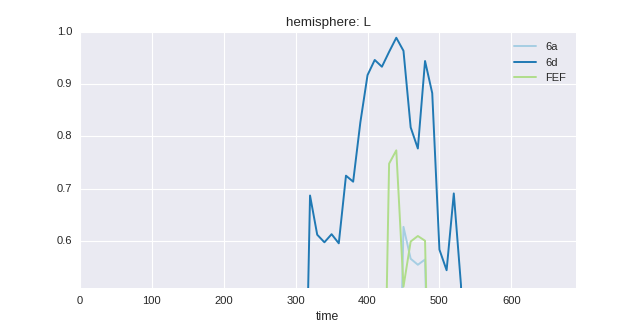

<IPython.core.display.Javascript object>


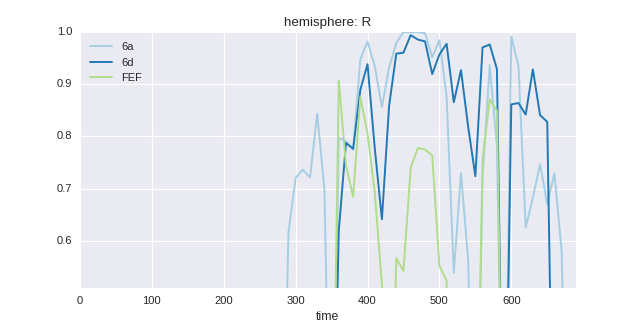

In [18]:
print(r_name)

region = 'premotor'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.region.apply(lambda s: s.startswith(region))]), 
                    [threshold, ylims[measure]], logy=logy[measure])

### clusters associated with a particular area

dot_x


<IPython.core.display.Javascript object>


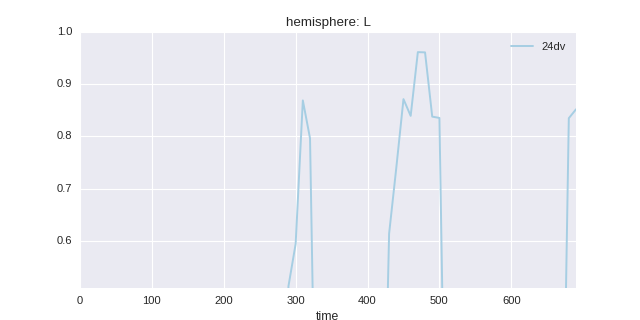

<IPython.core.display.Javascript object>


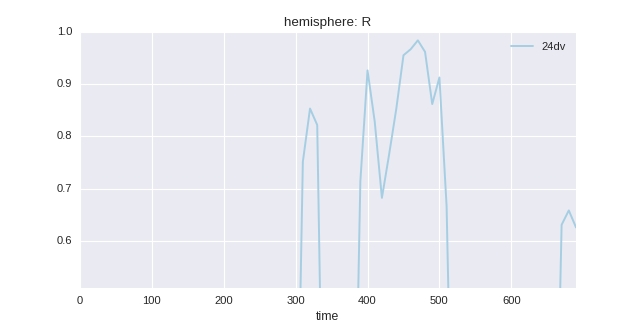

In [19]:
print(r_name)

# put the full area name in underscores such as '_1_' to match exactly
area = '_24dv_'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.label.apply(lambda s: s.find(area)>0)]), 
                    [threshold, ylims[measure]], logy=logy[measure])

### clusters with reliable effect around a particular time

dot_x


<IPython.core.display.Javascript object>


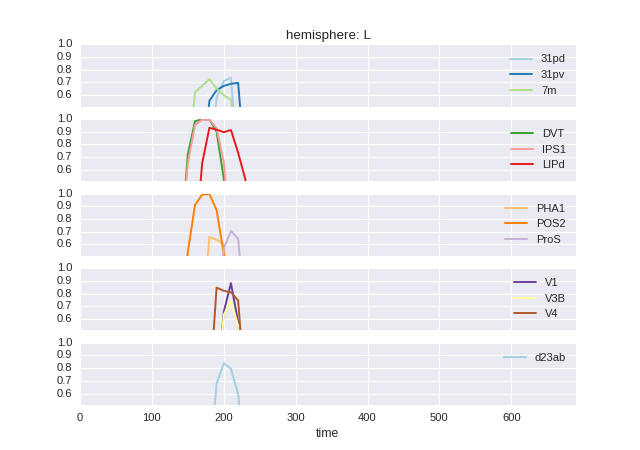

<IPython.core.display.Javascript object>


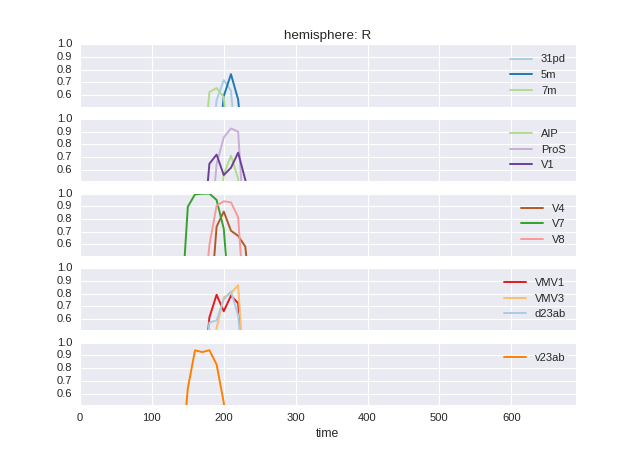

In [20]:
print(r_name)

time = 200

sv.show_timecourses(get_cluster_tcs(r_clusters[(time >= r_clusters.start_t) & (time <= r_clusters.end_t)]), 
                    [threshold, ylims[measure]], logy=logy[measure])

## Investigate consistency

In [21]:
src_df.loc[('L_8C_ROI-lh', 450)]

mu_mean         0.024796
mu_std          0.004097
mu_t            6.051603
mu_testval      0.000550
mu_p_large      0.936000
sigma_mean      0.014791
sigma_std       0.003744
theta_mean      0.582226
theta_std       0.092782
lp_mean        67.354911
lp_std          1.756538
overlap        -3.061309
consistency     0.032500
Name: (L_8C_ROI-lh, 450), dtype: float64

In [22]:
for cl in r_clusters.itertuples():
    r_clusters.loc[cl.Index, 'mean_consistency'] = (
        src_df.loc[(cl.label, slice(cl.start_t, cl.end_t)), 'consistency'].mean())

r_clusters[r_clusters.mean_consistency < 0.5]

,label,start_t,end_t,log10p,pval_corrected,region,mean_consistency
cluster,,,,,,,
11,L_10v_ROI-lh,550,570,-4.155024,6.338043e-04,anterior cingulate and medial prefrontal cortex,0.374167
66,L_33pr_ROI-lh,610,630,-4.680578,2.270399e-04,anterior cingulate and medial prefrontal cortex,0.477667
98,L_52_ROI-lh,180,190,-4.520593,3.082058e-04,insular and frontal opercular cortex,0.052750
109,L_5m_ROI-lh,360,390,-5.982309,1.522111e-05,paracentral lobular and mid cingulate cortex,0.478750
147,L_8BL_ROI-lh,420,430,-4.026945,8.240648e-04,dorsolateral prefrontal cortex,0.474000
152,L_8BM_ROI-lh,370,390,-4.411649,3.781938e-04,anterior cingulate and medial prefrontal cortex,0.415167
155,L_8C_ROI-lh,440,460,-5.489748,4.333801e-05,dorsolateral prefrontal cortex,0.092500
177,L_FOP2_ROI-lh,580,600,-4.927244,1.391708e-04,insular and frontal opercular cortex,0.137833
272,L_OP2-3_ROI-lh,180,190,-5.115736,9.575768e-05,posterior opercular cortex,0.123250
